[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mgahlot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160064    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,365
Trainable params: 213,365
Non-trainable params: 0
_________________________________________________________________
None
Train on 16029 samples, validate on 4153 samples
Epoch 1/5
16029/16029 [==============================] - 121s 8ms/step - loss: 0.2943 - accuracy: 0.8764 - val_loss: 0.1778 - val_accuracy: 0.9405
Epoch 2/5
16029/16029 [==============================] - 171s 11ms/step - loss: 0.1974 - accuracy: 0.9308 - val_loss: 0.1756 - val_accuracy: 0.9355
Epoch 3/5
16029/16029 [======

/Users/mgahlot/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


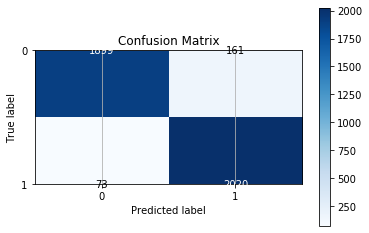

In [3]:
import numpy as np
import nltk
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from collections import Counter
import os
import getEmbeddings2
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

nltk.download('stopwords')

top_words = 5000
epoch_num = 5
batch_size = 64

def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()

if not os.path.isfile('./xtr_shuffled.npy') or \
    not os.path.isfile('./xte_shuffled.npy') or \
    not os.path.isfile('./ytr_shuffled.npy') or \
    not os.path.isfile('./yte_shuffled.npy'):
    getEmbeddings2.clean_data()


xtr = np.load('./xtr_shuffled.npy')
xte = np.load('./xte_shuffled.npy')
y_train = np.load('./ytr_shuffled.npy')
y_test = np.load('./yte_shuffled.npy')

cnt = Counter()
x_train = []
for x in xtr:
    x_train.append(x.split())
    for word in x_train[-1]:
        cnt[word] += 1  

# Storing most common words
most_common = cnt.most_common(top_words + 1)
word_bank = {}
id_num = 1
for word, freq in most_common:
    word_bank[word] = id_num
    id_num += 1

# Encode the sentences
for news in x_train:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

y_train = list(y_train)
y_test = list(y_test)

# Delete the short news
i = 0
while i < len(x_train):
    if len(x_train[i]) > 10:
        i += 1
    else:
        del x_train[i]
        del y_train[i]

# Generating test data
x_test = []
for x in xte:
    x_test.append(x.split())

# Encode the sentences
for news in x_test:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]


# Truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+2, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, batch_size=batch_size)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))

# Draw the confusion matrix
y_pred = model.predict_classes(X_test)
plot_cmat(y_test, y_pred)
